In [1]:
import numpy as np
import Normalization as nm
import matplotlib.pyplot as plt



In [2]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from sklearn.metrics.pairwise import pairwise_distances

Generate the points distribution as the problem which the normal kmeans cannot solve
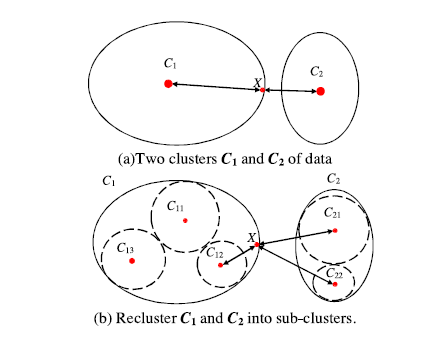

In [3]:
def d(u, v):
    diff = u - v
    return diff.dot(diff)


def cost(X, R, M):
    cost = 0
    for k in range(len(M)):
        # method 1
        # for n in range(len(X)):
        #     cost += R[n,k]*d(M[k], X[n])

        # method 2
        diff = X - M[k]
        sq_distances = (diff * diff).sum(axis=1)
        cost += (R[:,k] * sq_distances).sum()
    return cost


def plot_k_means(X, K, max_iter=20, beta=3.0, show_plots=False):
    N, D = X.shape
    # R = np.zeros((N, K))
    exponents = np.empty((N, K))

    # initialize M to random
    initial_centers = np.random.choice(N, K, replace=False)
    M = X[initial_centers]

    costs = []
    k = 0
    for i in range(max_iter):
        k += 1
        # step 1: determine assignments / resposibilities
        # is this inefficient?
        for k in range(K):
            for n in range(N):
                exponents[n,k] = np.exp(-beta*d(M[k], X[n]))
        R = exponents / (exponents.sum(axis=1, keepdims=True)+0.000000000001)


        # step 2: recalculate means
        # decent vectorization
        # for k in range(K):
        #     M[k] = R[:,k].dot(X) / R[:,k].sum()
        # oldM = M

        # full vectorization
        M = R.T.dot(X) / R.sum(axis=0, keepdims=True).T
        # print("diff M:", np.abs(M - oldM).sum())

        c = cost(X, R, M)
        costs.append(c)
        if i > 0:
            if np.abs(costs[-1] - costs[-2]) < 1e-5:
                break

        if len(costs) > 1:
            if costs[-1] > costs[-2]:
                pass
                # print("cost increased!")
                # print("M:", M)
                # print("R.min:", R.min(), "R.max:", R.max())

    if show_plots:
        plt.plot(costs)
        plt.title("Costs")
        plt.show()

        random_colors = np.random.random((K, 3))
        colors = R.dot(random_colors)
        plt.scatter(X[:,0], X[:,1], c=colors)
        plt.show()

    #print("Final cost", costs[-1])
    return M, R



In this section we use the Genetic Algorithm to find the best parameter

In [26]:
def cal_pop_fitness(d,g,pop):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function caulcuates the sum of products between each input and its corresponding weight.
    
    """
    parameter = np.zeros((pop.shape[0],6))
    parameter[:,0] = np.divide(np.asarray(pop[:,0]),(pop[:,0]+ pop[:,1]))
    parameter[:,1] = np.divide(pop[:,1],(pop[:,0]+ pop[:,1]))
    parameter[:,2] = np.multiply(np.divide(pop[:,2],(pop[:,2]+pop[:,3])),pop[:,6])
    parameter[:,3] = np.multiply(np.divide(pop[:,3],(pop[:,2]+pop[:,3])),pop[:,6])
    parameter[:,4] = pop[:,4]+ np.ones(pop.shape[0])
    parameter[:,5] = pop[:,5]+ np.ones(pop.shape[0])
    """
    
    
    fitness = [predict(int(v[4]),int(v[5]),v[0],v[1],v[2],v[3],g,d) for v in pop]
    print(fitness)
    return fitness

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.argmax(fitness)
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = np.random.uniform(-0.5, 0.5, 1)
        offspring_crossover[idx, 4:] = offspring_crossover[idx, 4:] + random_value
    return offspring_crossover

In [27]:
def findtheparameter(Data,group):
    # Inputs of the equation.

    # Number of the weights we are looking to optimize.
    num_weights = 6

    """
    Genetic algorithm parameters:
        Mating pool size
        Population size
    """
    sol_per_pop = 8
    num_parents_mating = 4

    # Defining the population size.
    pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
    #Creating the initial population.
    new_population = np.random.uniform(low=1, high=2, size=pop_size)
    print(new_population)

    num_generations = 200
    for generation in range(num_generations):
        print("Generation : ", generation)
        # Measing the fitness of each chromosome in the population.
        fitness = cal_pop_fitness(Data,group,new_population)

        # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, fitness, 
                                          num_parents_mating)

        # Generating next generation using crossover.
        offspring_crossover = crossover(parents,
                                           offspring_size=(pop_size[0]-parents.shape[0], num_weights))

        # Adding some variations to the offsrping using mutation.
        offspring_mutation = mutation(offspring_crossover)

        # Creating the new population based on the parents and offspring.
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation

        # The best result in the current iteration.
        #print("Best result : ", np.max(np.sum(new_population*equation_inputs, axis=1)))

    # Getting the best solution after iterating finishing all generations.
    #At first, the fitness is calculated for each solution in the final generation.
    fitness = cal_pop_fitness(Data,group,new_population)
    
    # Then return the index of that solution corresponding to the best fitness.
    best_match_idx = np.argmax(fitness)
    print(fitness)
    print("Best solution : ", new_population[best_match_idx, :])
    print("Best solution fitness : ", fitness[best_match_idx])
    
    

We Obtain the data which has been firstly separated into 2 groups

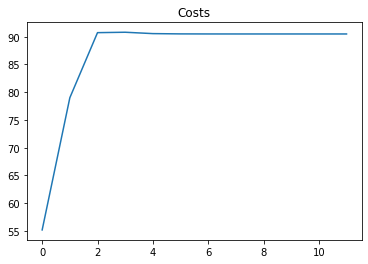

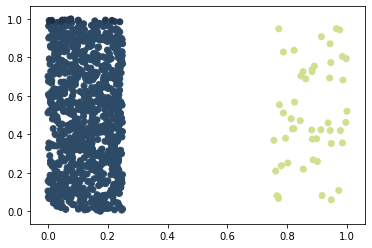

In [36]:
X = np.zeros((1000, 2))
X[:500,:] = np.random.multivariate_normal([0, 0], [[2, 0], [0, 20]], 500)
X[500:,:] = np.random.multivariate_normal([7, 0], [[1, 0], [0, 20]], 500)

X = np.zeros((1000,2))
X[:950,:] = np.array([0,0]) + np.random.rand(950,2)
X[950:, :] = np.array([3,0]) + np.random.rand(50,2)



N = nm.Normalization(X)

M,R=plot_k_means(N,2, beta=100,show_plots=True)
label = np.argmax(R,axis=1)

gnum = 2
Group = []
for i in range(gnum):
    index = np.where(label==i)
    Group.append(np.asarray(N[index,:]).reshape(len(index[0]),2))
    
print(F_measure())
#findtheparameter(N,Group)

Now,we need some metric to test the precison of cluttering methods, now we have F-measure
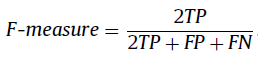

In [38]:
def F_measure(X1):
    C1 = X1[:950] 
    C2 = X1[950:]
    
    index1 = np.where(C1!=0)
    index2 = np.where(C2!=1)
    index3 = np.where(C2==0)
    index4 = np.where(C1==1)

    
    FN = len(index1[0]) + len(index2[0])
    FP = len(index3[0]) + len(index4[0])
    TP = 1000 - len(index1[0]) - len(index2[0])
    
    Fmeasure = 2*TP/(2*TP+FP+FN)
    return Fmeasure
    
    
    
    

Then we need to  separate the data into sub-class and cluttering 

In [39]:
def predict(k1,k2,w1,w2,r1,r2,Group,Data1):
    n,m = Data1.shape
    
    M1,R1=plot_k_means(Group[0],k1, beta=100,show_plots=True)
    M2,R2=plot_k_means(Group[1],k2, beta=100,show_plots=True)
    
    M = [M1,M2]
    P = []
    for i in range(2):
        for j in range(M[i].shape[0]):
            Tempx = np.asarray(Data1[:,0]).reshape((n,1))-np.ones((n,1))*M[i][j,0]
            Tempy = np.asarray(Data1[:,1]).reshape((n,1))-np.ones((n,1))*M[i][j,1]
            
            Tempx =  np.power(Tempx, r1)
            Tempy =  np.power(Tempy, r2)
            
            Temp = np.concatenate((Tempx,Tempy),axis=1)
            p = np.dot(Temp,np.asarray([w1,w2]).reshape(2,1))
            P.append(p)
    
    PP = P[0]
            
    for i in range(1,len(P)):
        PP = np.concatenate((P[i],PP),axis=1)
    
    result = np.argmin(PP,axis=1)
    result = np.where(result<k1,0,1)
    F1 = F_measure(result)
    return F1

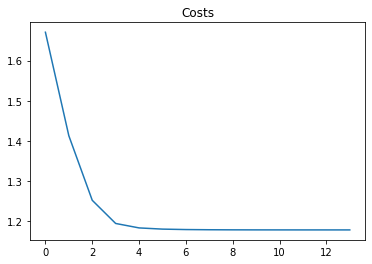

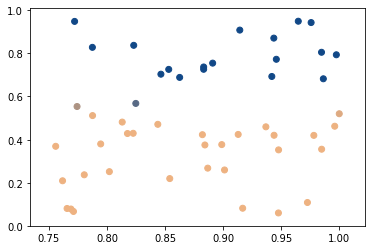

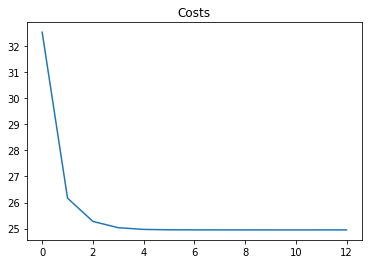

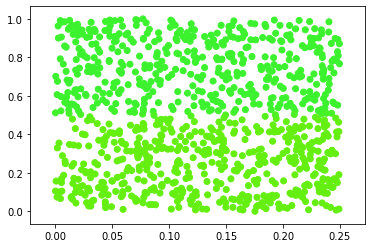

1.0


In [40]:
f = predict(2,2,1,1,2,2,Group,N)
print(f)
